In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import PoissonRegressor

# Project setup
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

from src.utils.data_partition import temporal_split
from src.utils.visualization import plot_prediction_interval_map, compare_prediction_maps, compare_hotspot_masks
from src.utils.spatial_processing import define_hotspot_by_crimes
from src.conformal.mapie_per_cell import apply_conformal_mapie_per_cell

# Load config
with open(os.path.join("..", "config.json"), "r") as f:
    config = json.load(f)

# Parameters
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
grid_size = (config["data_generation"]["rows"], config["data_generation"]["cols"])



In [2]:
# Load data
df = pd.read_csv("../data/examples/poisson_example_40x40.csv")

# Partition
days_per_month = 30
train_days = config["data_partition"]["train_months"] * days_per_month
calib_days = config["data_partition"]["calibration_months"] * days_per_month
test_days = config["data_partition"]["test_months"] * days_per_month

df_train, df_calib, df_test = temporal_split(
    df,
    train_days,
    train_days + calib_days,
    train_days + calib_days + test_days
)

# Features and targets
features = ["timestep", "row", "col"]
target = "count"

X_cal = df_calib[features].copy()
y_cal = df_calib[target].copy()

X_test = df_test[features].copy()
y_test = df_test[target].copy()

# Load pre-trained model
naive_model = joblib.load("../results/models/naive_cell_model.pkl")



In [3]:
# Apply conformal prediction per cell using pre-trained model
print("Applying MAPIE per cell using pre-trained Naive model...")
y_pred, y_min, y_max = apply_conformal_mapie_per_cell(
    X_cal, y_cal, X_test,
    base_estimator=naive_model,
    alpha=0.1,
    method="plus",
    grid_size=grid_size,
    prefit=True
)

Applying MAPIE per cell using pre-trained Naive model...


Processing rows: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s]


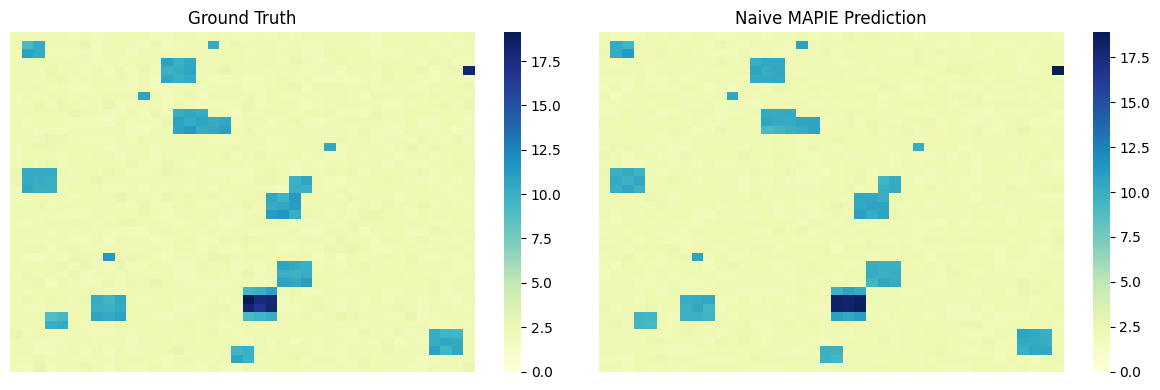

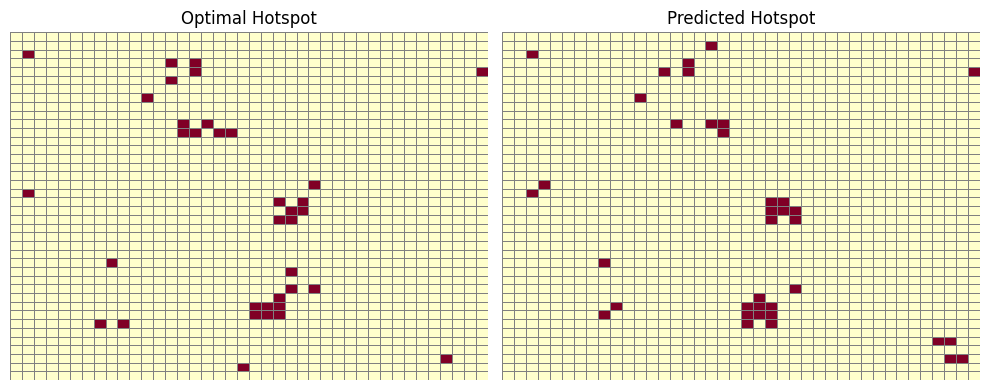

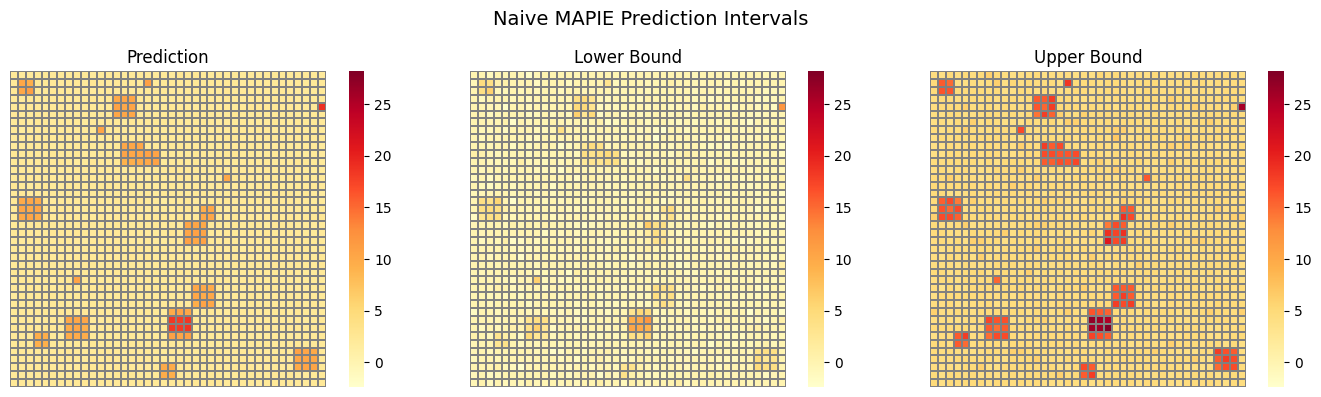

In [7]:
def aggregate_by_cell(X, y, grid_size, aggfunc="sum"):
    """
    Aggregate values per spatial cell.

    Parameters:
    - X: DataFrame with 'row' and 'col' columns
    - y: Series or array with values to aggregate
    - grid_size: (rows, cols) tuple
    - aggfunc: aggregation function (default: 'sum')

    Returns:
    - grid: 2D numpy array with aggregated values
    """
    df = X.copy()
    df["count"] = y
    grouped = df.groupby(["row", "col"])["count"].agg(aggfunc)
    grid = np.zeros(grid_size)
    for (r, c), val in grouped.items():
        grid[r, c] = val
    return grid

# Asignar predicción directamente
grid_pred = y_pred  # Ya está en formato de grilla (rows x cols)

# Convertir ground truth a grilla
grid_true = aggregate_by_cell(X_test, y_test, grid_size,aggfunc="mean")

# Definir máscaras de hotspots
hotspot_optimal = define_hotspot_by_crimes(grid_true, hotspot_percentage)
hotspot_pred = define_hotspot_by_crimes(grid_pred, hotspot_percentage)

# Visualizar mapas de predicción
compare_prediction_maps(
    [grid_true, grid_pred],
    ["Ground Truth", "Naive MAPIE Prediction"],
    vmin=0, vmax=None, figsize=(12, 4)
)

# Visualizar hotspots
compare_hotspot_masks(
    [hotspot_optimal, hotspot_pred],
    ["Optimal Hotspot", "Predicted Hotspot"],
    ncols=2, figsize=(10, 4)
)

# Visualizar intervalos de predicción
plot_prediction_interval_map(
    grid_pred, y_min, y_max,
    title="Naive MAPIE Prediction Intervals"
)


In [11]:
y_pred.shape

(40, 40)